In [1]:
REPO = '..'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'

import os
import sys
import glob
import scanpy as sc
import anndata
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
import warnings
import commentjson
import pickle

### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
_stderr = sys.stderr
null = open(os.devnull,'wb')
import dill
scplus_obj = dill.load(open(f'{RESULT_OBJ}/scenic/tumor/scplus_obj.pkl', 'rb'))

## Simplifying and filtering SCENIC+ output

In [3]:
scplus_obj.uns.keys()

dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'Pseudobulk', 'TF_cistrome_correlation', 'eRegulon_AUC_thresholds'])

In [4]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


## eRegulon enrichment scores

In [5]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(f'{RESULT_OBJ}/scenic/tumor/region_ranking.pkl', 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(f'{RESULT_OBJ}/scenic/tumor/gene_ranking.pkl', 'rb')) #load ranking calculated using the wrapper function
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 5)

## eRegulon dimensionality reduction

In [6]:
from scenicplus.dimensionality_reduction import run_eRegulons_tsne, run_eRegulons_umap
run_eRegulons_umap(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_UMAP', #overwrite previously calculated UMAP
)
run_eRegulons_tsne(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_tSNE', #overwrite previously calculated tSNE
)

In [7]:
scplus_obj.metadata_cell['Cellstate']

CTATAACCAATGCCCG-1___CCG1112_23_T1_A           Tumor.ER-I
TCATGTTTCGCTAGTG-1___CCG1112_16_T1_A1          Tumor.ER-I
CATTATGAGTTAACCA-1___CCG1112_18_T2_A     Tumor.Cell_Cycle
GGTCTTGAGTTTCCGC-1___CCG1112_21_T3_A           Tumor.ER-I
CGATTTGCAAGTTATC-1___CCG1112_14_T2_A           Tumor.ER-I
                                               ...       
GCACCTAAGTAACCCG-1___CCG1112_23_T1_A           Tumor.ER-I
AACCCGCAGTAAGGGC-1___CCG1112_14_T2_A           Tumor.ER-I
GGGTTTGTCCCATAGG-1___CCG1112_21_T3_A           Tumor.ER-I
GAACCTGTCGTTAACA-1___CCG1112_02_T2_A          Tumor.ER-II
CTCCCTGAGGTCGATT-1___CCG1112_14_T2_A           Tumor.ER-I
Name: Cellstate, Length: 10587, dtype: object

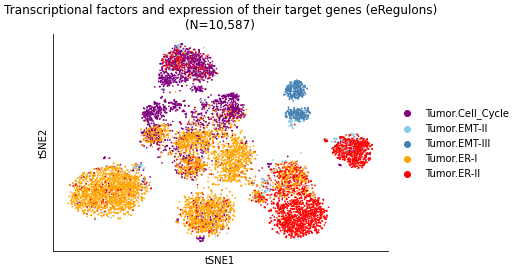

In [8]:

adata = anndata.AnnData(obs=scplus_obj.metadata_cell[['Cellstate']],
                        obsm={'X_tsne':scplus_obj.dr_cell['eRegulons_tSNE'].values}
                       )
adata.obs['Cellstate'] = pd.Categorical(adata.obs['Cellstate'])
adata.uns['Cellstate_colors'] =[ COLOR_PAlETTE['Cellstate'][x] for x in adata.obs['Cellstate'].cat.categories]
sc.pl.tsne(adata,color=['Cellstate'],
           title=[f"Transcriptional factors and expression of their target genes (eRegulons)\n(N={adata.shape[0]:,})"])

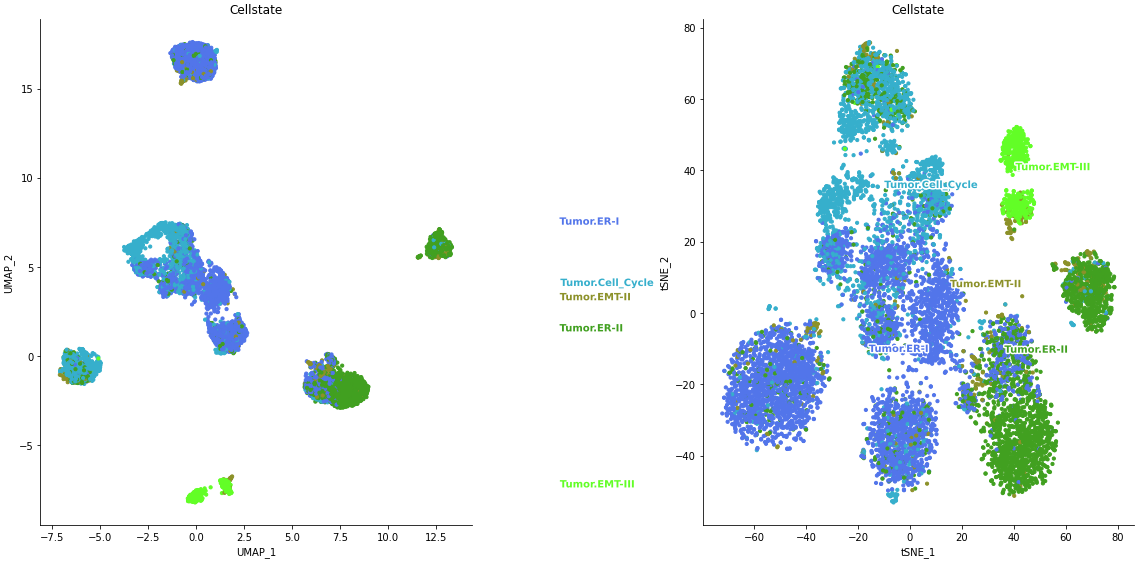

In [9]:
from scenicplus.dimensionality_reduction import plot_metadata_given_ax
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#specify color_dictionary


fig, axs = plt.subplots(ncols=2, figsize = (16, 8))
plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[0],
    reduction_name = 'eRegulons_UMAP',
    variable = 'Cellstate', #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
    # color_dictionary={'GEX_celltype': color_dict}
)
plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[1],
    reduction_name = 'eRegulons_tSNE',
    variable = 'Cellstate', #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
    # color_dictionary={'GEX_celltype': color_dict}
)
fig.tight_layout()
sns.despine(ax = axs[0]) #remove top and right edge of axis border
sns.despine(ax = axs[1]) #remove top and right edge of axis border
plt.show()

## correlation between TF expression and target region enrichment scores (AUC values)

In [10]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'Cellstate',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'Cellstate',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'Cellstate',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'Cellstate',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

## select eRegulons for which the correlaiton coefficient is above 0.70 or below -0.75

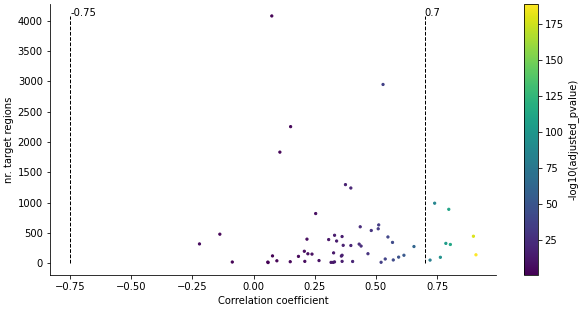

In [11]:
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.75, 0.70],
        'n_targets': 0
}
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

## Overlap of predicted target regions

In [12]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 8 eRegulons


## Overlap of target regions of the top 5 TFs per cell type based on the Regulon Specificity Score (RSS).

In [13]:
from scenicplus.RSS import *
regulon_specificity_scores(
        scplus_obj,
        variable = 'Cellstate',
        auc_key = 'eRegulon_AUC_filtered',
        signature_keys = ['Region_based'],
        selected_regulons = [x for x in scplus_obj.uns['selected_eRegulon']['Region_based'] if '-' not in x],
        out_key_suffix = '_filtered')

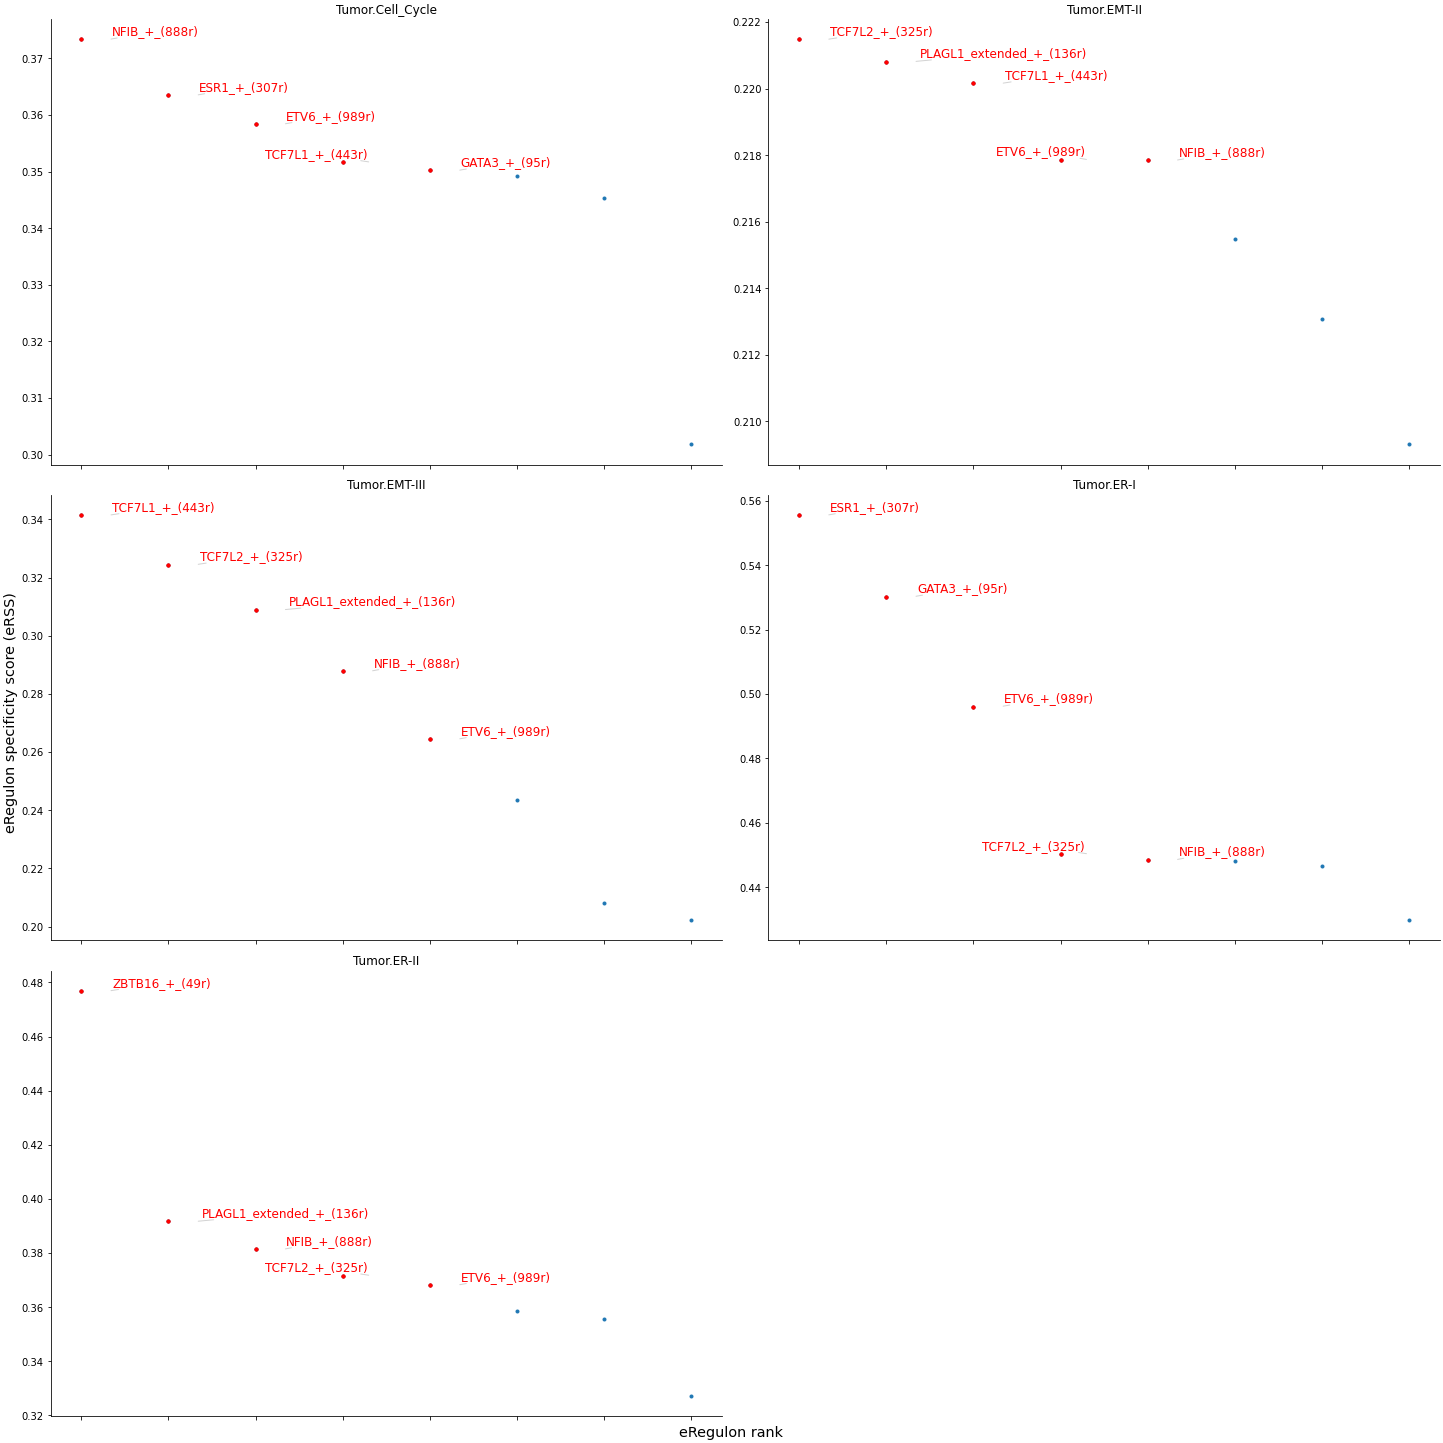

In [14]:
plot_rss(scplus_obj, 'Cellstate_filtered', num_columns=2, top_n=5, figsize = (20, 20))

In [15]:
scplus_obj.uns['selected_eRegulon']['Gene_based']

['TCF7L2_+_(219g)',
 'ZBTB16_+_(29g)',
 'GATA3_+_(106g)',
 'TCF7L1_+_(240g)',
 'ESR1_+_(206g)',
 'NFIB_+_(471g)',
 'PLAGL1_extended_+_(100g)',
 'ETV6_+_(731g)']

In [16]:
from scenicplus.plotting.dotplot import generate_dotplot_df
dotplot_df=generate_dotplot_df(
     scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'Cellstate',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based']
)

In [17]:
size_val='Target region enrichment\n(Scaled)'
color_val='TF expression\n(Scaled)'
dotplot_df.rename(columns={
    'size_val':size_val,
    'color_val':color_val
},inplace=True)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 78.67083333333333 mm


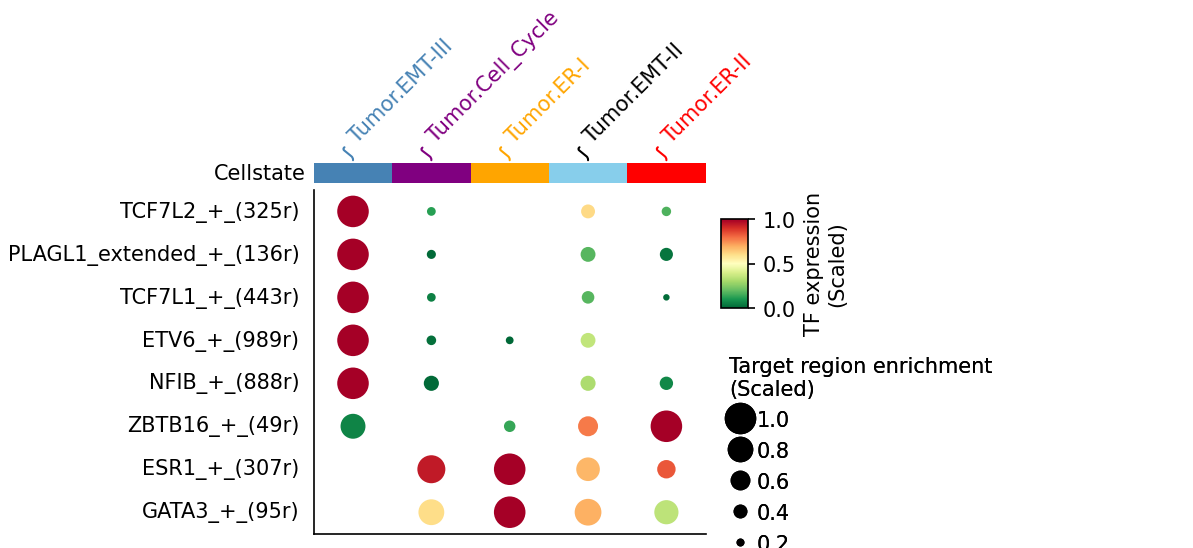

In [18]:

from PyComplexHeatmap import DotClustermapPlotter
plt.figure(figsize=(3, 3),dpi=150)
df_col = dotplot_df[['index']].drop_duplicates().set_index('index')
df_col['Cellstate'] = df_col.index
col_ha = HeatmapAnnotation(
                           label=anno_label(df_col['Cellstate'],
                                                 colors={k:v for k,v in COLOR_PAlETTE['Cellstate'].items() if k in df_col['Cellstate']},
                                                 merge=True,rotation=45),
                           Cellstate=anno_simple(df_col['Cellstate'],
                                                 colors={k:v for k,v in COLOR_PAlETTE['Cellstate'].items() if k in df_col['Cellstate']},
                                                 legend=False),
                           verbose=0,label_side='left')

cm = DotClustermapPlotter(data=dotplot_df, x='index',y='eRegulon_name',value=color_val,c=color_val,s=size_val,
                          row_cluster=True,col_cluster=True,spines=True,
                          cmap='RdYlGn_r',ratio=200,dot_legend_kws={'frameon':False},
                         top_annotation=col_ha,show_rownames=True,row_names_side='left')

## Coverage plot

In [19]:
tumor_MP_gmt_path = f'{RESULT_TABLE}/MPs/Tumor/MP_Programs.gmt'
ref_ITH=pd.read_table(tumor_MP_gmt_path,header=None,index_col=0).drop([1],axis=1).T
with open(f'{RESULT_TABLE}/MPs/Tumor/MP_anno_map.pickle', "rb") as input_file:
    MP_anno_map= pickle.load(input_file)
    
ref_ITH.columns = ref_ITH.columns.map(MP_anno_map)

In [20]:
scplus_obj.uns.keys()

dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'Pseudobulk', 'TF_cistrome_correlation', 'eRegulon_AUC_thresholds', 'eRegulon_metadata_filtered', 'eRegulon_signatures_filtered', 'eRegulon_AUC_filtered', 'selected_eRegulon', 'RSS'])

In [21]:
from scenicplus.plotting.coverageplot import coverage_plot
import pyranges as pr

In [22]:
pr_gtf = pr.read_gtf(f"{EXTERNAL_DATA}/gencode.v32.annotation.gtf.gz")
pr_consensus_bed = pr.read_bed(f'{RESULT_OBJ}/Consensus_Peaks/consensus_regions.bed')

In [23]:
 scplus_obj.uns.keys()

dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'Pseudobulk', 'TF_cistrome_correlation', 'eRegulon_AUC_thresholds', 'eRegulon_metadata_filtered', 'eRegulon_signatures_filtered', 'eRegulon_AUC_filtered', 'selected_eRegulon', 'RSS'])

In [24]:
# from scenicplus.utils import get_interaction_pr
# pr_interact = get_interaction_pr(scplus_obj, 'hsapiens', 'hg38', inplace = False, subset_for_eRegulons_regions = True, eRegulons_key = 'eRegulons')

In [25]:
scplus_obj.metadata_cell['Cellstate_format'] = scplus_obj.metadata_cell['Cellstate'].str.replace('[.+()-/\ ]','_')
scplus_obj.metadata_cell['Cellstate_show'] = scplus_obj.metadata_cell['Cellstate_format'].map(lambda x:x.replace('Tumor_','').replace('_',' '))
cellstate_maps = scplus_obj.metadata_cell[['Cellstate','Cellstate_format']].drop_duplicates().set_index('Cellstate')['Cellstate_format'].to_dict()
bw_dict  = {
    os.path.basename(x).replace('.bw','').replace('Tumor_','').replace('_',' '):x 
    for x in glob.glob(f'{RESULT_OBJ}/Consensus_Peaks/consensus_peak_calling/pseudobulk_bw_files/*.bw') if os.path.basename(x).replace('.bw','') in scplus_obj.metadata_cell['Cellstate_format'].unique()
}

color_dict = { cellstate_maps[k].replace('Tumor_','').replace('_',' '):v for k,v in COLOR_PAlETTE['Cellstate'].items() if k in cellstate_maps}

In [26]:
scplus_obj.metadata_cell['Cellstate_show'].unique()

array(['ER I', 'Cell Cycle', 'EMT II', 'ER II', 'EMT III'], dtype=object)

In [27]:
tf_df = scplus_obj.uns['eRegulon_metadata_filtered']
# tf_df = tf_df.loc[tf_df.Gene.isin(ref_ITH['EMT-III'].tolist()),:]
show_tf = tf_df.loc[(tf_df.Region_signature_name=='TCF7L2_+_(325r)')&(tf_df.Gene.isin(ref_ITH['EMT-III'].tolist())),:]
show_tf.sort_values('R2G_importance',ascending=False)

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
152,TCF7L2_+_(325r),TCF7L2_+_(219g),TCF7L2,False,chr6:56671820-56672320,DST,0.068129,0.197274,0.013440,0.013440,0.964561,1,0.518492,0.500117,0.500117,TCF7L2_+_+
249,TCF7L2_+_(325r),TCF7L2_+_(219g),TCF7L2,False,chr2:160214556-160215056,ITGB6,0.059879,0.261319,0.015648,0.015648,0.275451,1,0.353179,0.097283,0.097283,TCF7L2_+_+
15,TCF7L2_+_(325r),TCF7L2_+_(219g),TCF7L2,False,chr1:214573278-214573778,PTPN14,0.047117,0.337740,0.015913,0.015913,0.860617,1,0.491638,0.423112,0.423112,TCF7L2_+_+
261,TCF7L2_+_(325r),TCF7L2_+_(219g),TCF7L2,False,chr4:88771826-88772326,FAM13A,0.046353,0.289730,0.013430,0.013430,0.329916,1,0.518649,0.171111,0.171111,TCF7L2_+_+
345,TCF7L2_+_(325r),TCF7L2_+_(219g),TCF7L2,False,chr20:53162225-53162725,TSHZ2,0.041960,0.366273,0.015369,0.015369,1.148697,1,0.488440,0.561069,0.561069,TCF7L2_+_+
19,TCF7L2_+_(325r),TCF7L2_+_(219g),TCF7L2,False,chr1:214552175-214552675,PTPN14,0.041372,0.409882,0.016957,0.016957,0.860617,1,0.491638,0.423112,0.423112,TCF7L2_+_+
262,TCF7L2_+_(325r),TCF7L2_+_(219g),TCF7L2,False,chr4:88801967-88802467,FAM13A,0.035668,0.309418,0.011036,0.011036,0.329916,1,0.518649,0.171111,0.171111,TCF7L2_+_+
204,TCF7L2_+_(325r),TCF7L2_+_(219g),TCF7L2,False,chr18:5895913-5896413,L3MBTL4,0.032869,0.457294,0.015031,0.015031,0.629520,1,0.394438,0.248307,0.248307,TCF7L2_+_+
203,TCF7L2_+_(325r),TCF7L2_+_(219g),TCF7L2,False,chr18:6482469-6482969,L3MBTL4,0.031942,0.447638,0.014299,0.014299,0.629520,1,0.394438,0.248307,0.248307,TCF7L2_+_+
16,TCF7L2_+_(325r),TCF7L2_+_(219g),TCF7L2,False,chr1:214377901-214378401,PTPN14,0.021546,0.324923,0.007001,0.007001,0.860617,1,0.491638,0.423112,0.423112,TCF7L2_+_+


### EMT-III genes related regulons

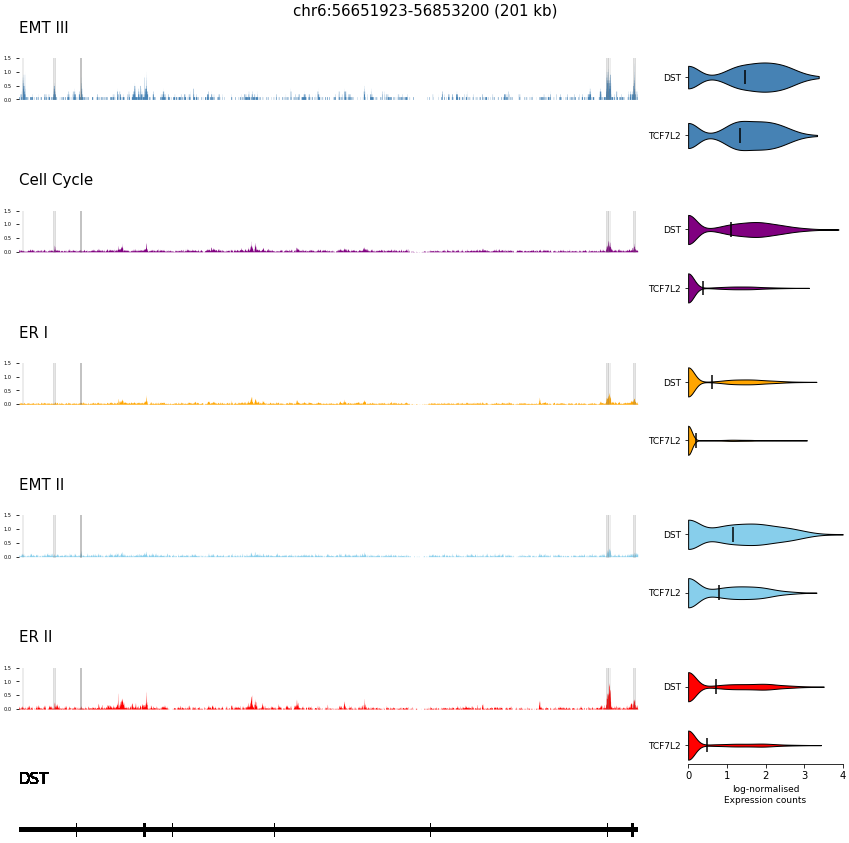

In [40]:
gene = 'DST'
offset = 1000
regions = tf_df.loc[tf_df.Gene==gene,'Region'].str.split(':',expand=True)
regions.columns = ['chr','pos']
regions[['start','end']] = regions['pos'].str.split('-',expand=True).astype(int)
show_region = regions['chr'].unique()[0] + ':' + f"{regions['start'].min()-offset }-{regions['end'].max()+offset }"

fig = coverage_plot(scplus_obj,bw_dict=bw_dict,region=show_region,
                    pr_gtf=pr_gtf,pr_interact = None,pr_consensus_bed=pr_consensus_bed,
                    genes_violin_plot=['TCF7L2',gene],meta_data_key='Cellstate_show',
                    plot_order=['EMT III','Cell Cycle','ER I','EMT II','ER II'],
                    color_dict=color_dict,
                    figsize = (12,12),
                    # region_bed_height=0.1,
                    gene_label_offset=-10,
                    fontsize_dict={'bigwig_label': 15, 'title': 15,
                                   'bigwig_tick_label': 5,'gene_label': 15, 'violinplots_xlabel': 9, 'violinplots_ylabel': 9},
                    width_ratios_dict={'bigwig': 4, 'violinplots': 1},
                    height_ratios_dict = {'bigwig_violin': 10, 'genes': 2, 'arcs': 0})
for _,row in regions.iterrows():
    for i in range(0,10,2):
        fig.axes[i].fill_between([row['start'],row['end']],0,2,alpha=0.1,color='gray')

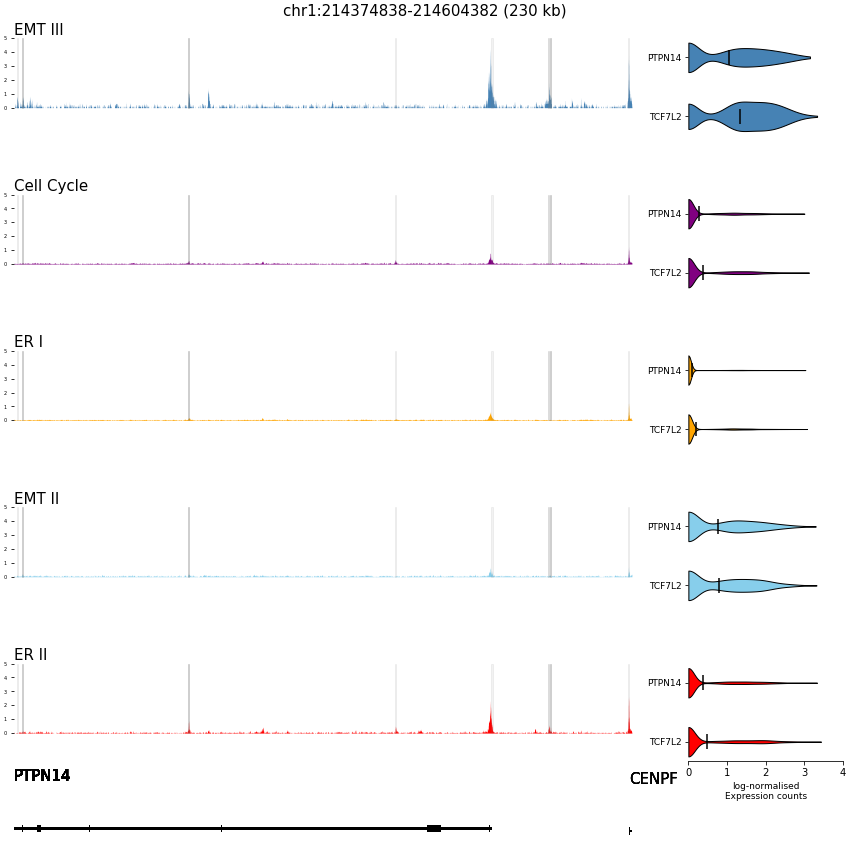

In [41]:
gene = 'PTPN14'
offset = 1000
regions = tf_df.loc[tf_df.Gene==gene,'Region'].str.split(':',expand=True)
regions.columns = ['chr','pos']
regions[['start','end']] = regions['pos'].str.split('-',expand=True).astype(int)
show_region = regions['chr'].unique()[0] + ':' + f"{regions['start'].min()-offset }-{regions['end'].max()+offset }"

fig = coverage_plot(scplus_obj,bw_dict=bw_dict,region=show_region,
                    pr_gtf=pr_gtf,pr_interact = None,pr_consensus_bed=pr_consensus_bed,
                    genes_violin_plot=['TCF7L2',gene],meta_data_key='Cellstate_show',
                    plot_order=['EMT III','Cell Cycle','ER I','EMT II','ER II'],
                    color_dict=color_dict,
                    figsize = (12,12),
                    # region_bed_height=0.1,
                    gene_label_offset=-10,
                    fontsize_dict={'bigwig_label': 15, 'title': 15,
                                   'bigwig_tick_label': 5,'gene_label': 15, 'violinplots_xlabel': 9, 'violinplots_ylabel': 9},
                    width_ratios_dict={'bigwig': 4, 'violinplots': 1},
                    height_ratios_dict = {'bigwig_violin': 10, 'genes': 2, 'arcs': 0})
for _,row in regions.iterrows():
    for i in range(0,10,2):
        fig.axes[i].fill_between([row['start'],row['end']],0,5,alpha=0.1,color='gray')

### ER-I

#### ESR1_+_(307r)

In [30]:
tf_df = scplus_obj.uns['eRegulon_metadata_filtered']
show_tf = tf_df.loc[(tf_df.Region_signature_name=='ESR1_+_(307r)')&(tf_df.Gene.isin(ref_ITH['ER-I'].tolist())),:]
show_tf.sort_values('R2G_importance',ascending=False)

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
322,ESR1_+_(307r),ESR1_+_(206g),ESR1,False,chr7:42292964-42293464,GLI3,0.037258,0.264991,0.009873,0.009873,0.455991,1,0.279578,0.127485,0.127485,ESR1_+_+
195,ESR1_+_(307r),ESR1_+_(206g),ESR1,False,chr14:37602844-37603344,TTC6,0.035988,0.297718,0.010714,0.010714,0.574131,1,0.427914,0.245678,0.245678,ESR1_+_+
342,ESR1_+_(307r),ESR1_+_(206g),ESR1,False,chr13:71712932-71713432,DACH1,0.030687,0.188903,0.005797,0.005797,0.660243,1,0.349917,0.231030,0.231030,ESR1_+_+


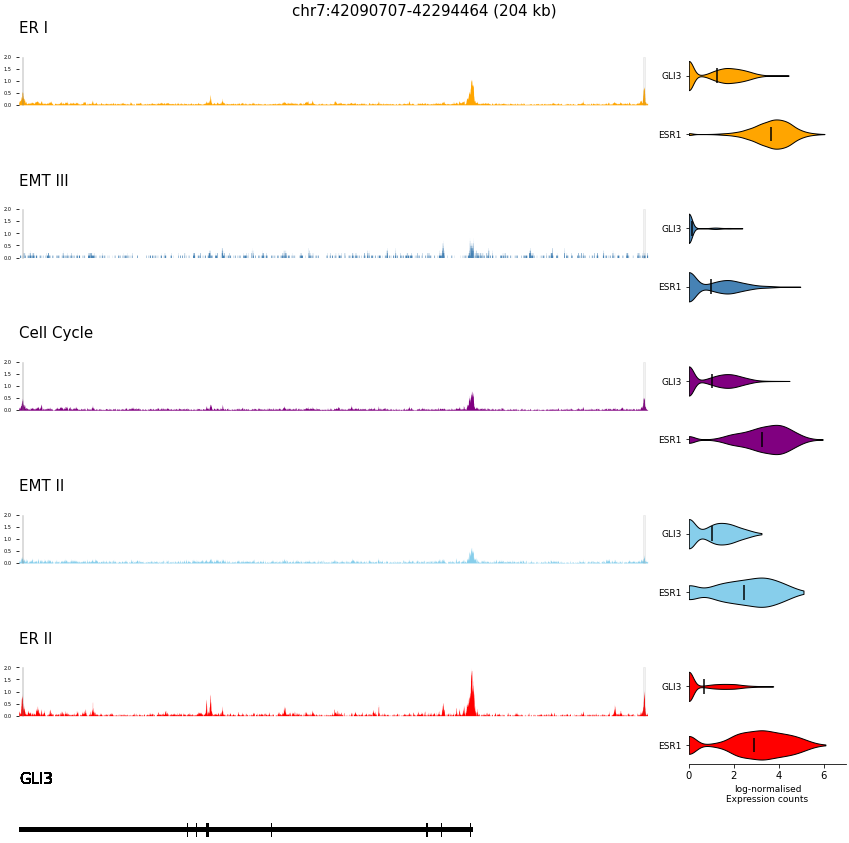

In [38]:
gene = 'GLI3'
offset = 1000
regions = tf_df.loc[tf_df.Gene==gene,'Region'].str.split(':',expand=True)
regions.columns = ['chr','pos']
regions[['start','end']] = regions['pos'].str.split('-',expand=True).astype(int)
show_region = regions['chr'].unique()[0] + ':' + f"{regions['start'].min()-offset }-{regions['end'].max()+offset }"

fig = coverage_plot(scplus_obj,bw_dict=bw_dict,region=show_region,
                    pr_gtf=pr_gtf,pr_interact = None,pr_consensus_bed=pr_consensus_bed,
                    genes_violin_plot=['ESR1',gene],meta_data_key='Cellstate_show',
                    plot_order=['ER I','EMT III','Cell Cycle','EMT II','ER II'],
                    color_dict=color_dict,
                    figsize = (12,12),
                    # region_bed_height=0.1,
                    gene_label_offset=-10,
                    fontsize_dict={'bigwig_label': 15, 'title': 15,
                                   'bigwig_tick_label': 5,'gene_label': 15, 'violinplots_xlabel': 9, 'violinplots_ylabel': 9},
                    width_ratios_dict={'bigwig': 4, 'violinplots': 1},
                    height_ratios_dict = {'bigwig_violin': 10, 'genes': 2, 'arcs': 0})
for _,row in regions.iterrows():
    for i in range(0,10,2):
        fig.axes[i].fill_between([row['start'],row['end']],0,2,alpha=0.1,color='gray')

#### GATA3_+_(95r)

In [32]:
show_tf = tf_df.loc[(tf_df.Region_signature_name=='GATA3_+_(95r)')&(tf_df.Gene.isin(ref_ITH['ER-I'].tolist())),:]
show_tf.sort_values('R2G_importance',ascending=False)

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
34,GATA3_+_(95r),GATA3_+_(106g),GATA3,False,chr2:149005566-149006066,LYPD6B,0.052328,0.347614,0.018190,0.018190,0.824947,1,0.245874,0.202833,0.202833,GATA3_+_+
33,GATA3_+_(95r),GATA3_+_(106g),GATA3,False,chr10:37162358-37162858,ANKRD30A,0.050040,0.681791,0.034117,0.034117,0.979388,1,0.476081,0.466268,0.466268,GATA3_+_+
19,GATA3_+_(95r),GATA3_+_(106g),GATA3,False,chr14:37650733-37651233,TTC6,0.035185,0.055354,0.001948,0.001948,0.731537,1,0.471282,0.344760,0.344760,GATA3_+_+


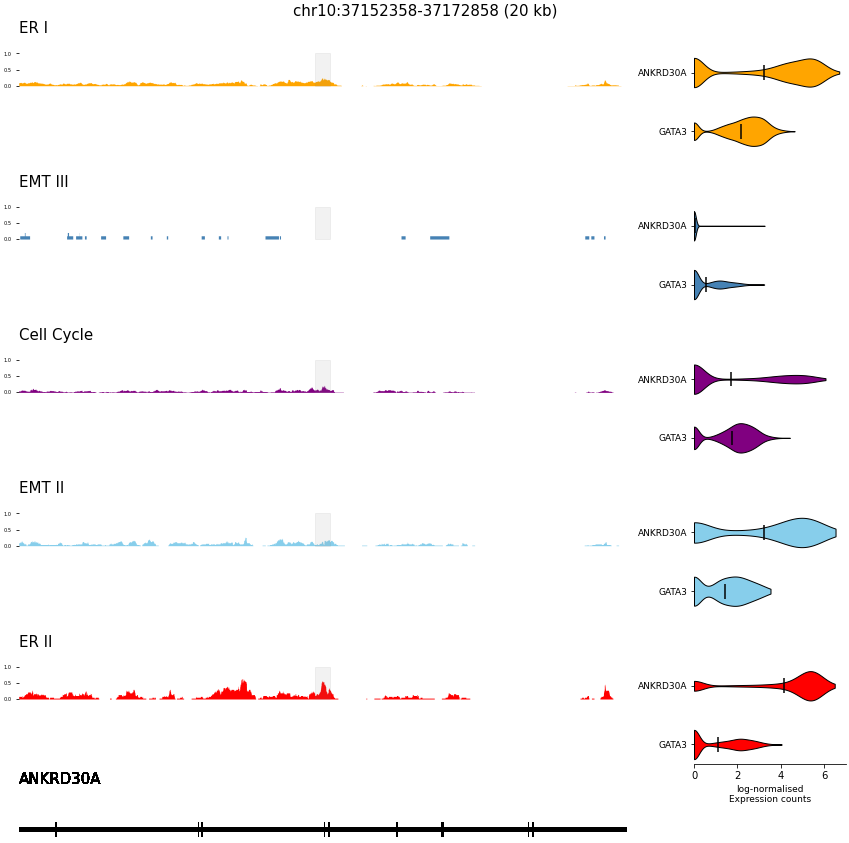

In [39]:
gene = 'ANKRD30A'
offset = 10000
regions = tf_df.loc[tf_df.Gene==gene,'Region'].str.split(':',expand=True)
regions.columns = ['chr','pos']
regions[['start','end']] = regions['pos'].str.split('-',expand=True).astype(int)
show_region = regions['chr'].unique()[0] + ':' + f"{regions['start'].min()-offset }-{regions['end'].max()+offset }"

fig = coverage_plot(scplus_obj,bw_dict=bw_dict,region=show_region,
                    pr_gtf=pr_gtf,pr_interact = None,pr_consensus_bed=pr_consensus_bed,
                    genes_violin_plot=['GATA3',gene],meta_data_key='Cellstate_show',
                    plot_order=['ER I','EMT III','Cell Cycle','EMT II','ER II'],
                    color_dict=color_dict,
                    figsize = (12,12),
                    # region_bed_height=0.1,
                    gene_label_offset=-10,
                    fontsize_dict={'bigwig_label': 15, 'title': 15,
                                   'bigwig_tick_label': 5,'gene_label': 15, 'violinplots_xlabel': 9, 'violinplots_ylabel': 9},
                    width_ratios_dict={'bigwig': 4, 'violinplots': 1},
                    height_ratios_dict = {'bigwig_violin': 10, 'genes': 2, 'arcs': 0})
for _,row in regions.iterrows():
    for i in range(0,10,2):
        fig.axes[i].fill_between([row['start'],row['end']],0,1,alpha=0.1,color='gray')